In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsimport
from utilities import clean_data

In [31]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

In [32]:
df.dropna(axis=0, inplace=True)
df.head()

,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes
20,2017-09-23,24S,19140.0,75.0,10.0,196.0,18853.0
21,2017-09-30,24S,20089.0,65.0,13.0,187.0,17755.0
22,2017-10-07,24S,21007.0,55.0,12.0,144.0,15733.0
23,2017-10-14,24S,22034.0,46.0,13.0,118.0,14802.0
24,2017-10-21,24S,22425.0,46.0,10.0,119.0,14450.0


In [39]:
df.to_csv('../data/cleaned_data.csv', index=False, sep=';')

In [50]:
df = pd.read_csv('../data/cleaned_data.csv', sep=';', header=0, parse_dates=['period_end_date'], index_col='period_end_date')

In [51]:
df["business_entity_doing_business_as_name"].value_counts()

business_entity_doing_business_as_name
Versace            455
C&A Brasil         455
Coach              455
Tarte Cosmetics    455
Armani             455
                  ... 
Sculptra            59
Finding Unicorn     44
Pop Mart            44
Temu                12
ShopGoodwill         7
Name: count, Length: 704, dtype: int64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232172 entries, 2017-09-23 to 2023-09-16
Data columns (total 6 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   business_entity_doing_business_as_name  232172 non-null  object 
 1   followers                               232172 non-null  float64
 2   pictures                                232172 non-null  float64
 3   videos                                  232172 non-null  float64
 4   comments                                232172 non-null  float64
 5   likes                                   232172 non-null  float64
dtypes: float64(5), object(1)
memory usage: 12.4+ MB


In [53]:
# get data for one
df_versace = df[df["business_entity_doing_business_as_name"] == "Versace"]

In [54]:
df_versace.head()

,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes
period_end_date,,,,,,
2015-01-03,Versace,3013544.0,33.0,3.0,7111.0,742976.0
2015-01-10,Versace,3052258.0,28.0,1.0,7193.0,685187.0
2015-01-17,Versace,3091251.0,56.0,0.0,12023.0,1288836.0
2015-01-24,Versace,3124897.0,67.0,0.0,12552.0,1460174.0
2015-01-31,Versace,3179576.0,91.0,0.0,16593.0,2054621.0


### build forecasting model for one brand

In [55]:
df_versace.describe()

,followers,pictures,videos,comments,likes
count,4.550000e+02,455.000000,455.000000,455.000000,4.550000e+02
mean,1.794143e+07,60.683516,8.389011,19088.705495,3.830508e+06
std,8.861745e+06,24.131542,5.801060,13882.181945,2.572646e+06
min,3.013544e+06,18.000000,0.000000,1806.000000,3.359130e+05
25%,9.927106e+06,41.000000,4.000000,9117.500000,1.859912e+06
50%,1.927831e+07,57.000000,7.000000,14751.000000,3.205928e+06
75%,2.557413e+07,79.000000,12.000000,25666.500000,5.452523e+06
max,3.131274e+07,122.000000,29.000000,77862.000000,1.536503e+07


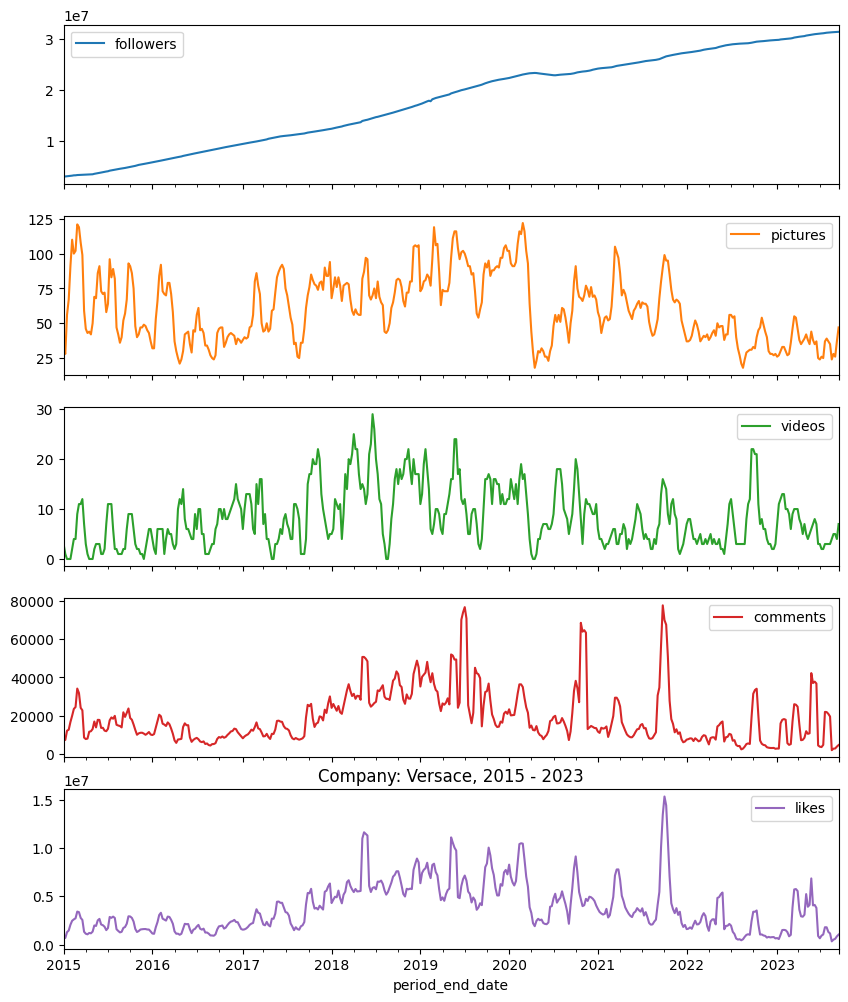

In [57]:
start_year = '2015'
end_year = '2023'
df_versace[start_year:end_year].plot(subplots=True, figsize=(10,12))
plt.title(f'Company: Versace, {start_year} - {end_year}')
plt.show()

### LSTM

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [6]:
df = pd.read_csv('../data/cleaned_data.csv', sep=';', header=0, parse_dates=['period_end_date'], index_col='period_end_date')

In [7]:
df_versace = df[df["business_entity_doing_business_as_name"] == "Versace"]
df_versace_followers = df_versace[['followers']]

In [7]:
#! pip install keras
#!pip install tensorflow
#!pip install tensorflow-macos

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [23]:
class LSTM_Forecast:
    def __init__(self, df, company_name, target_column, n_input, n_feature, test_ratio, plot = False):
        self.df = df
        self.company_name = company_name
        self.n_input = n_input
        self.n_feature = n_feature
        self.test_ratio = test_ratio
        self.target_column = target_column
        self.company_data = self.get_company_data()
        self.train, self.test = self.train_test_split()
        
        self.scaler = MinMaxScaler()
        self.scaled_train, self.scaled_test = self.scale_data()
        self.train_generator = self.create_generator()
        self.model = self.create_model()
        self.train_model()
        self.test_predictions = self.predict()
        self.true_predictions = self.inverse_transform()
        self.test = self.add_predictions()
        self.mse = self.mean_squared_error()
        self.plot_predictions() if plot else None
        
        
    def get_company_data(self):
        print(f"Load data for {self.company_name}...")
        company_data = self.df[self.df["business_entity_doing_business_as_name"] == self.company_name]
        return company_data[[self.target_column]]
    
    def train_test_split(self):
        print("Splitting data into train and test sets...")
        train_size = int(len(self.company_data) * (1 - self.test_ratio))
        #test_size = len(self.company_data) - train_size
        train, test = self.company_data.iloc[0:train_size], self.company_data.iloc[train_size:len(self.company_data)]
        return train, test
    
    def scale_data(self):
        print("Scaling data...")
        self.scaler.fit(self.train)
        scaled_train = self.scaler.transform(self.train)
        scaled_test = self.scaler.transform(self.test)
        return scaled_train, scaled_test
    
    def create_generator(self):
        print("Creating TimeseriesGenerator...")
        train_generator = TimeseriesGenerator(self.scaled_train, self.scaled_train, length=self.n_input, batch_size=5)
        return train_generator
    
    def create_model(self):
        print(f"Build the model")
        model = Sequential()
        model.add(LSTM(128, activation='relu', input_shape=(self.n_input, self.n_feature), return_sequences=True))
        model.add(LSTM(128, activation='relu', return_sequences=True))
        model.add(LSTM(128, activation='relu', return_sequences=False))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        return model
    
    def train_model(self):
        print(f"Training the model...")
        self.model.fit(self.train_generator, epochs=25)
    
    def predict(self):
        print(f"Predicting...")
        test_predictions = []
        first_eval_batch = self.scaled_train[-self.n_input:]
        first_eval_batch = first_eval_batch.reshape((1, self.n_input, self.n_feature))
        current_batch = first_eval_batch.reshape((1, self.n_input, self.n_feature))
        for i in range(len(self.test)):
            current_pred = self.model.predict(current_batch)[0]
            test_predictions.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
        return test_predictions
    
    def inverse_transform(self):
        true_predictions = self.scaler.inverse_transform(self.test_predictions)
        return true_predictions
    
    def add_predictions(self):
        self.test['pred_'+self.target_column] = self.true_predictions
        return self.test
    
    def mean_squared_error(self):
        mse = np.mean((self.test[self.target_column] - self.test['pred_'+self.target_column])**2)
        print(f'Mean Squared Error: {mse}')
        return mse
    
    def plot_predictions(self):
        self.test.plot(figsize=(10,4))
        plt.title(f'{self.company_name} {self.target_column} Forecast')
        plt.show()    
    

Load data for Versace...
Splitting data into train and test sets...
Scaling data...
Creating TimeseriesGenerator...
Build the model
Training the model...


/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
20/71 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0897

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0523
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0256
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0247
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0389
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0184
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0335
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0191
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0203
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0308
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0131
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0181
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0154
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0153
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0093
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0091
Epoch 16/25
71/7

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions


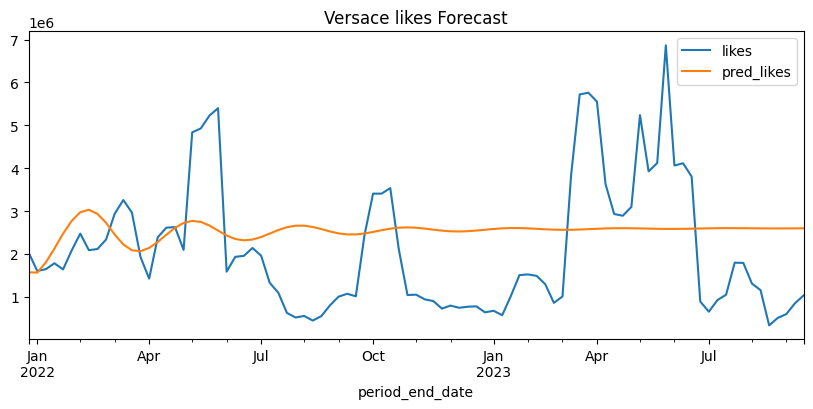

In [24]:
model_likes = LSTM_Forecast(df, 'Versace', 'likes', 12, 1, 0.2, plot=True)

In [25]:
top_brands = df["business_entity_doing_business_as_name"].value_counts().head(5).index
top_brands

Index(['Versace', 'C&A Brasil', 'Coach', 'Tarte Cosmetics', 'Armani'], dtype='object', name='business_entity_doing_business_as_name')

In [26]:
model_list_for_brands = []
for brand in top_brands:
    model = LSTM_Forecast(df, brand, 'followers', 12, 1, 0.2)
    model_list_for_brands.append(model)

Load data for Versace...
Splitting data into train and test sets...
Scaling data...
Creating TimeseriesGenerator...
Build the model
Training the model...
Epoch 1/25


/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2070

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1240
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.8560e-04
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8341e-04
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4335e-04
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8431e-04
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6139e-04
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6243e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2825e-04
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2697e-04
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0120
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions
/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2716

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1420
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.7358e-04
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2535e-04
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0015
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0073
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7844e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5506e-04
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2980e-04
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5045e-04
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0104
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss:

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions
/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1492

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0878
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.9717e-04
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.6756e-04
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4682e-04
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.8015e-04
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0193
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.9065e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8260e-04
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.1425e-04
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9214e-04
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9056e-04
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2072e-04
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 1

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions
/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2886

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1554
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3308e-04
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.5244e-04
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8389e-04
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.4615e-04
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.2900e-04
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4806e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.7536e-04
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2636e-04
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8137e-04
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions
/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/71 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3147

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1585
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9638e-04
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.3526e-04
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1490e-04
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1794e-04
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6750e-04
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.8474e-04
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9309e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4012e-04
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0034
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3097e-04
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2743e-04
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.6882e-04
Epoch 15/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions


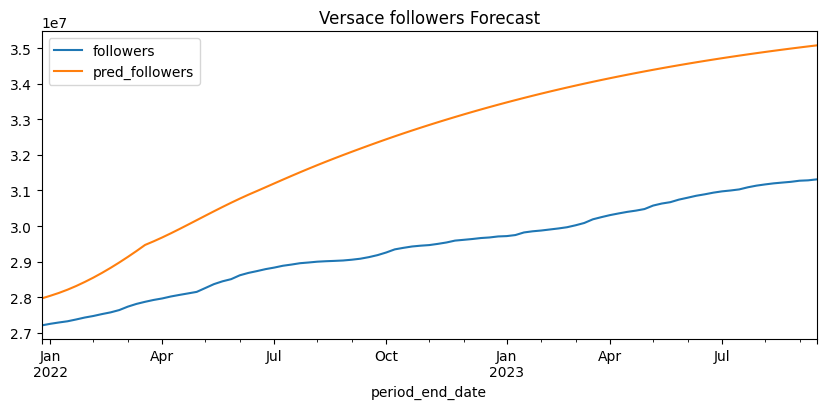

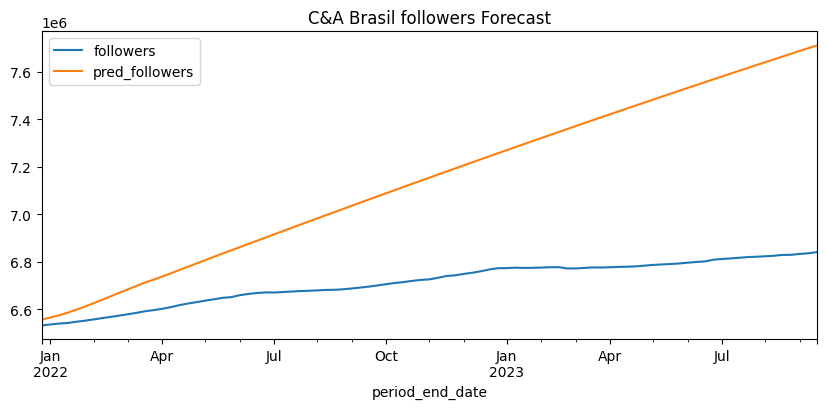

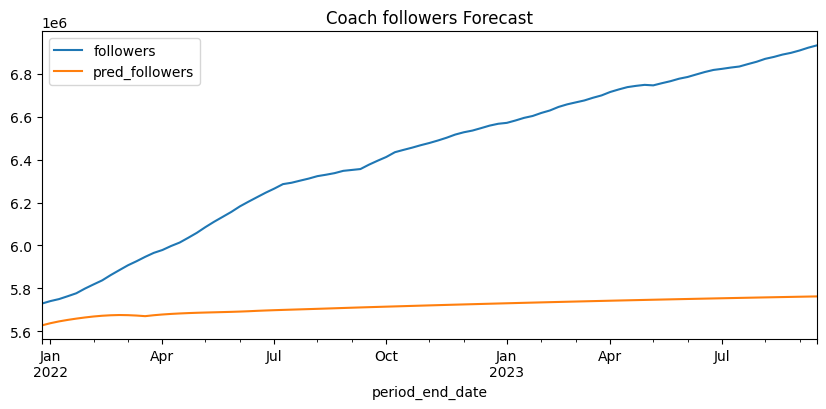

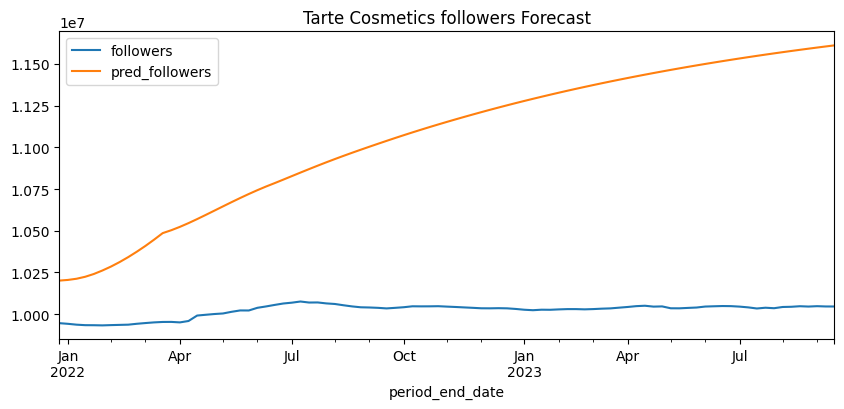

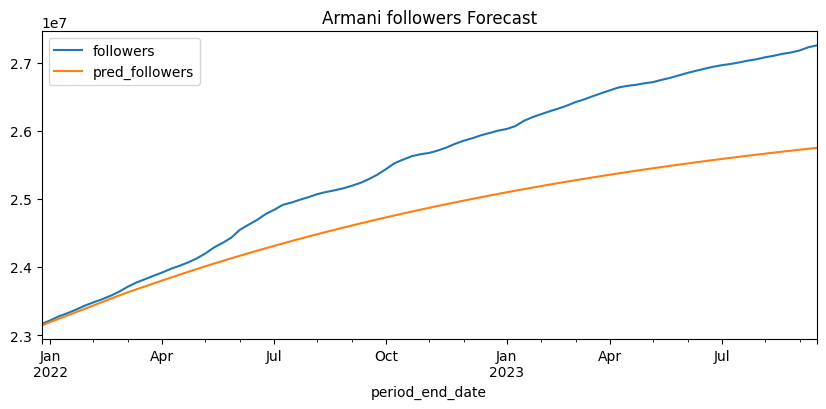

In [27]:
for model in model_list_for_brands:
    model.plot_predictions()

### Try other models
- LinearRegression: linear is not suitable
- LogisticRegression:

Conclusion: Regression is not suitable

In [38]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()

In [39]:
df.head()

,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes
0,2017-05-06,24S,NaN,NaN,NaN,NaN,NaN
1,2017-05-13,24S,NaN,6.0,3.0,57.0,1765.0
2,2017-05-20,24S,NaN,6.0,3.0,57.0,1765.0
3,2017-05-27,24S,NaN,6.0,3.0,57.0,1765.0
4,2017-06-03,24S,NaN,24.0,3.0,109.0,3922.0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298040 entries, 0 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         298040 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  298040 non-null  object        
 2   followers                               236313 non-null  float64       
 3   pictures                                294176 non-null  float64       
 4   videos                                  288438 non-null  float64       
 5   comments                                293958 non-null  float64       
 6   likes                                   294288 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 15.9+ MB


In [42]:
df.dropna(axis=0, inplace=True)
# deal with the datetime
df['period_end_date'] = pd.to_datetime(df['period_end_date'])

# Extract date components
df['year'] = df['period_end_date'].dt.year
df['month'] = df['period_end_date'].dt.month
df['day'] = df['period_end_date'].dt.day

# Encode cyclical features (e.g., month)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# encode the column 'business_entity_doing_business_as_name' using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['brand_id'] = le.fit_transform(df['business_entity_doing_business_as_name'])
df.head()

,period_end_date,business_entity_doing_business_as_name,followers,pictures,videos,comments,likes,year,month,day,month_sin,month_cos,brand_id
20,2017-09-23,24S,19140.0,75.0,10.0,196.0,18853.0,2017,9,23,-1.000000,-1.836970e-16,0
21,2017-09-30,24S,20089.0,65.0,13.0,187.0,17755.0,2017,9,30,-1.000000,-1.836970e-16,0
22,2017-10-07,24S,21007.0,55.0,12.0,144.0,15733.0,2017,10,7,-0.866025,5.000000e-01,0
23,2017-10-14,24S,22034.0,46.0,13.0,118.0,14802.0,2017,10,14,-0.866025,5.000000e-01,0
24,2017-10-21,24S,22425.0,46.0,10.0,119.0,14450.0,2017,10,21,-0.866025,5.000000e-01,0


In [43]:
df_followers = df[['followers', 'brand_id', 'year', 'month', 'day', 'month_sin', 'month_cos']]
df_followers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232172 entries, 20 to 298039
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   followers  232172 non-null  float64
 1   brand_id   232172 non-null  int64  
 2   year       232172 non-null  int32  
 3   month      232172 non-null  int32  
 4   day        232172 non-null  int32  
 5   month_sin  232172 non-null  float64
 6   month_cos  232172 non-null  float64
dtypes: float64(3), int32(3), int64(1)
memory usage: 11.5 MB


Mean Squared Error: 190223003581545.78


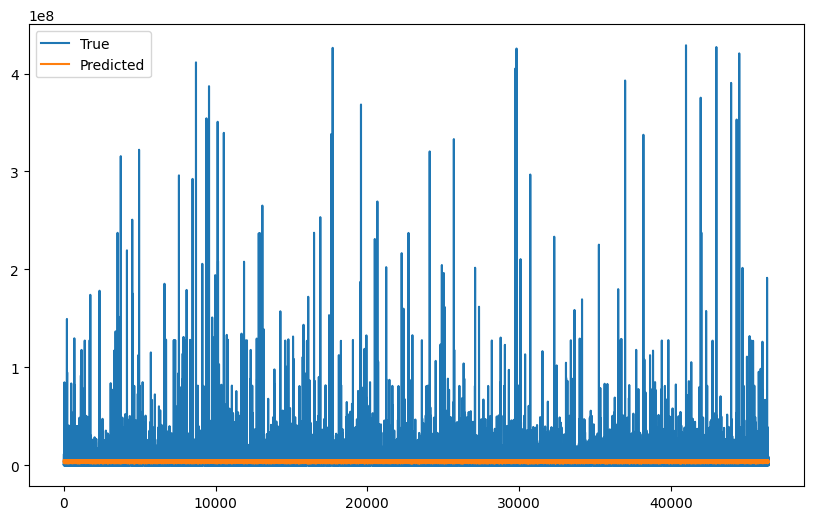

In [46]:
# train a linear regression model using followers as the target variable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df_followers.drop('followers', axis=1)
y = df_followers['followers']
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
# plot the y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/754670401.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_followers['followers'] = pd.cut(df_followers['followers'], bins=3, labels=[0, 1, 2])
/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.998406374501992


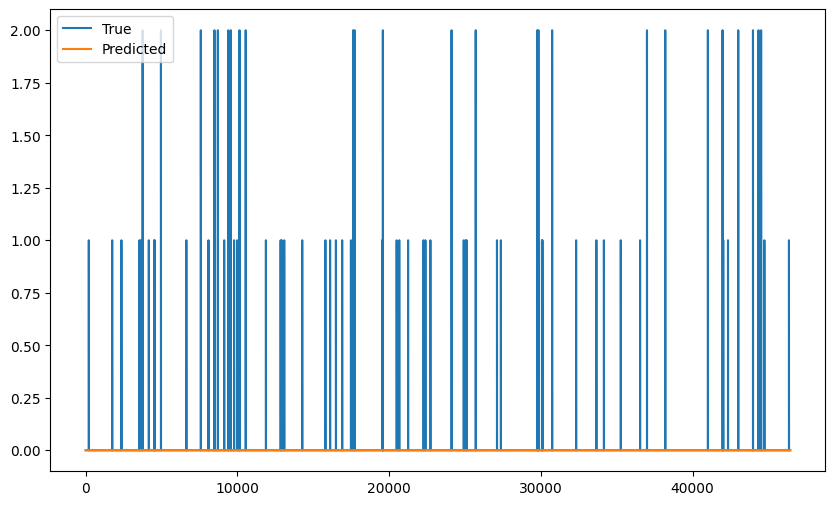

In [47]:
# train a logistic regression model using followers as the target variable
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

df_followers['followers'] = pd.cut(df_followers['followers'], bins=3, labels=[0, 1, 2])
X = df_followers.drop('followers', axis=1)
y = df_followers['followers']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
# plot the y_test and y_pred
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


### Test LSTM on rate of change

In [28]:
from utilities import clean_data, derivatives_data

In [29]:
df, df_brands, df_allbrands, brands, compsets, compset_groups, groups_bycompset = clean_data()
df_rate_of_change, df_curvature = derivatives_data(df)

In [30]:
df_rate_of_change.head()

,period_end_date,business_entity_doing_business_as_name,change in pictures,change in videos,change in comments,change in likes,change in followers
0,2017-05-06,24S,NaN,NaN,NaN,NaN,NaN
1,2017-05-13,24S,6.0,3.0,57.0,1765.0,NaN
2,2017-05-20,24S,6.0,3.0,57.0,1765.0,NaN
3,2017-05-27,24S,6.0,3.0,57.0,1765.0,NaN
4,2017-06-03,24S,24.0,3.0,109.0,3922.0,NaN


In [31]:
df_curvature.head()

,period_end_date,business_entity_doing_business_as_name,curvature in pictures,curvature in videos,curvature in comments,curvature in likes,curvature in followers
0,2017-05-06,24S,NaN,NaN,NaN,NaN,NaN
1,2017-05-13,24S,NaN,NaN,NaN,NaN,NaN
2,2017-05-20,24S,0.0,0.0,0.0,0.0,NaN
3,2017-05-27,24S,0.0,0.0,0.0,0.0,NaN
4,2017-06-03,24S,18.0,0.0,52.0,2157.0,NaN


In [32]:
df_curvature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298040 entries, 0 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         298040 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  298040 non-null  object        
 2   curvature in pictures                   293977 non-null  float64       
 3   curvature in videos                     287971 non-null  float64       
 4   curvature in comments                   293752 non-null  float64       
 5   curvature in likes                      294094 non-null  float64       
 6   curvature in followers                  235241 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 15.9+ MB


In [33]:
df_rate_of_change.dropna(axis=0, inplace=True)
df_curvature.dropna(axis=0, inplace=True)

In [34]:
df_rate_of_change.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231658 entries, 21 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         231658 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  231658 non-null  object        
 2   change in pictures                      231658 non-null  float64       
 3   change in videos                        231658 non-null  float64       
 4   change in comments                      231658 non-null  float64       
 5   change in likes                         231658 non-null  float64       
 6   change in followers                     231658 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 14.1+ MB


In [35]:
df_curvature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231023 entries, 22 to 298039
Data columns (total 7 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   period_end_date                         231023 non-null  datetime64[ns]
 1   business_entity_doing_business_as_name  231023 non-null  object        
 2   curvature in pictures                   231023 non-null  float64       
 3   curvature in videos                     231023 non-null  float64       
 4   curvature in comments                   231023 non-null  float64       
 5   curvature in likes                      231023 non-null  float64       
 6   curvature in followers                  231023 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 14.1+ MB


Load data for Versace...
Splitting data into train and test sets...
Scaling data...
Creating TimeseriesGenerator...
Build the model
Training the model...
Epoch 1/25


/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/71 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014

/Users/yaoyao/miniconda3/envs/datathon/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.8150e-04
Epoch 2/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.4466e-04
Epoch 3/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.9188e-05
Epoch 4/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0840e-04
Epoch 5/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2370e-04
Epoch 6/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1614e-04
Epoch 7/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2712e-04
Epoch 8/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7579e-04
Epoch 9/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3656e-04
Epoch 10/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3500e-04
Epoch 11/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1616e-04
Epoch 12/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3600e-04
Epoch 13/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2390e-04
Epoch 14/25
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1846e-04
Epoch 15/25
71/71 ━━━━━━━━━

/var/folders/yd/z6_kxvwj695fk45rl_9jd3k40000gn/T/ipykernel_47735/304637765.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test['pred_'+self.target_column] = self.true_predictions


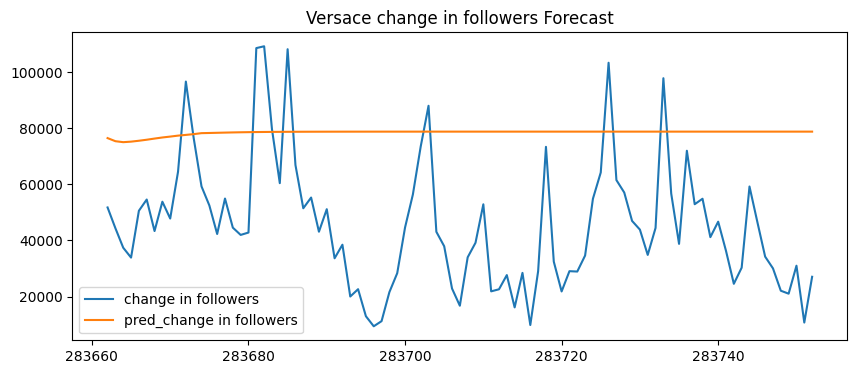

In [36]:
model_rate = LSTM_Forecast(df_rate_of_change, 'Versace', 'change in followers', 12, 1, 0.2, plot=True)